# note: jax and classes are tricky
still worth it imo 
https://jax.readthedocs.io/en/latest/faq.html#strategy-1-jit-compiled-helper-function

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, value_and_grad, jit, vmap
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.linalg import cho_factor, cho_solve
from jax.example_libraries import optimizers
from jax.scipy.linalg import cholesky
from jax import lax 
from scipy.stats import differential_entropy
import matplotlib.pyplot as plt
from jax import jit, tree_util
from jax import nn 
plt.rcParams['font.size'] = 14
from matplotlib.gridspec import GridSpec


In [2]:
class OlfactorySensing:
    def __init__(self, N=100, n=2, M=30, P=1000, sigma_0=1e-2, sigma_c=2): 
        self.N = N
        self.n = n
        self.M = M
        self.P = P
        self.sigma_0 = sigma_0
        self.sigma_c = sigma_c
        self.set_sigma()
        self.W = None  # Initialize W as None; it may be set later with set_random_W
        self.vasicek_window = None  # This will be set when draw_cs is called

    def _tree_flatten(self):
        # Treat `W` as a dynamic value, while the rest are static
        children = (self.W,)  # W is the only dynamic value
        aux_data = {
            'N': self.N,
            'n': self.n,
            'M': self.M,
            'P': self.P,
            'sigma_0': self.sigma_0,
            'sigma_c': self.sigma_c,
            'vasicek_window': self.vasicek_window,
        }
        return (children, aux_data)

    @classmethod
    def _tree_unflatten(cls, aux_data, children):
        # Recreate an instance of OlfactorySensing from children and aux_data
        instance = cls(
            N=aux_data['N'],
            n=aux_data['n'],
            M=aux_data['M'],
            P=aux_data['P'],
            sigma_0=aux_data['sigma_0'],
            sigma_c=aux_data['sigma_c']
        )
        instance.W = children[0]
        instance.vasicek_window = aux_data['vasicek_window']
        return instance

    def set_sigma(self): 
        self.sigma = lambda x: x / (1 + x) 

    def draw_c(self, key): 
        c = jnp.zeros(self.N)
        non_zero_indices = jax.random.choice(key, self.N, shape=(self.n,), replace=False)
        concentrations = jax.random.lognormal(key, sigma=self.sigma_c, shape=(self.n,))
        c = c.at[non_zero_indices].set(concentrations)
        return c

    def draw_cs(self, key):
        keys = jax.random.split(key, self.P)
        self.vasicek_window = jax.lax.stop_gradient(jnp.round(jnp.sqrt(self.P) + 0.5)).astype(int)
        return jnp.array([self.draw_c(k) for k in keys]).T

    def set_random_W(self, key): 
        self.W = 1 / jnp.sqrt(self.N) * jax.random.normal(key, shape=(self.M, self.N))

    def compute_activity(self, W, c, key): 
        pre_activations = W @ c
        r = self.sigma(pre_activations) + self.sigma_0 * jax.random.normal(key, shape=pre_activations.shape) 
        return r

    # @jit # for some reason, this breaks because of self.vasicek_window in _pad_along_last_axis. This is very confusing. If I hardcode that, it works, but it takes >3 minutes to compile. 
    def compute_entropy_of_r(self, W, c, key):
        r = self.compute_activity(W, c, key)
        entropy = self.compute_sum_of_marginal_entropies(r) - self.compute_information_of_r(r)
        return entropy

    # @jit 
    def compute_sum_of_marginal_entropies(self, r):
        compute_entropy_vmap = vmap(self._vasicek_entropy, in_axes=0)
        # Apply the vectorized function
        marginal_entropies = compute_entropy_vmap(r)
        # Sum the marginal entropies
        return jnp.sum(marginal_entropies)

    # @jit 
    def compute_information_of_r(self, r): 
        M, P = r.shape
        G = norm.ppf((rankdata(r.T, axis=0) / (P + 1)), loc=0, scale=1)
        bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2))
        cov_matrix = jnp.cov(G, rowvar=False)
        chol_decomp = cholesky(cov_matrix)
        log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
        I = -(log_det - bias_correction)
        return I
    
    def _pad_along_last_axis(self, X):
        first_value = X[0]
        last_value = X[-1]
        # Use `lax.full_like` to create padded arrays
        Xl = lax.full_like(x=jnp.empty((self.vasicek_window,)), fill_value=first_value)
        Xr = lax.full_like(x=jnp.empty((self.vasicek_window,)), fill_value=last_value)
        return jnp.concatenate((Xl, X, Xr))

    def _vasicek_entropy(self, X):
        n = X.shape[-1]
        X = jnp.sort(X, axis=-1)
        X = self._pad_along_last_axis(X)
        start1 = 2 * self.vasicek_window
        length = self.P
        differences = lax.dynamic_slice(X, (start1,), (length, )) - lax.dynamic_slice(X, (0,), (length,))
        logs = jnp.log(n / (2 * self.vasicek_window) * differences)
        return jnp.mean(logs, axis=-1)

# Register the custom class as a PyTree with JAX
tree_util.register_pytree_node(
    OlfactorySensing,
    OlfactorySensing._tree_flatten,
    OlfactorySensing._tree_unflatten
)


# Optimization

In [3]:
def objective(W, cs, key, os, param):
    if param=='square':
        W = W**2
    else: 
        W = nn.softplus(W) 
    return - os.compute_entropy_of_r(W, cs, key)[0]  # Negate for maximization

def step(i, opt_state, opt_update, get_params, key, os, param):
    cs = os.draw_cs(key)
    W = get_params(opt_state)
    loss, grads = value_and_grad(lambda W: objective(W, cs, key, os, param))(W)
    opt_state = opt_update(i, grads, opt_state)
    return opt_state, loss

def run_optimization(os, key, W_init, n_steps=int(2e3), param='square', stepsize=1e-3): 
    opt_init, opt_update, get_params = optimizers.adam(stepsize)
    opt_state = opt_init(W_init)
    ent_values = []
    vals = []
    print_interval = round(n_steps / 10) 
    for i in range(n_steps):
        key, subkey = jax.random.split(key)
        opt_state, entropy_value = step(i, opt_state, opt_update, get_params, subkey, os, param)
        ent_values.append(entropy_value)
        vals.append(get_params(opt_state)) 
        if i % print_interval == 0:
            print(f"Step {i}, Estimated Entropy: {-entropy_value}")

    W_opt = get_params(opt_state).reshape((os.M, os.N))
    print("Optimized W:", W_opt)
    return ent_values, W_opt 

In [4]:
def mirror_descent(n_steps, W_init, c_init, key, lr, os, phi, psi):
    value_and_grad = jax.value_and_grad(lambda *args: -os.compute_entropy_of_r(*args)) # minus sign because we want to maximize entropy! Just remember your values are negative. 
    trajectory = [W_init]
    entropies = [-os.compute_entropy_of_r(W_init, c_init, key)] 
    W_current = W_init
    print_interval = round(n_steps / 10) 
    for n in range(n_steps):
        key, subkey = jax.random.split(key)
        cs = os.draw_cs(subkey)
        value, grad = value_and_grad(W_current, cs, subkey) 
        W_new = phi(psi(W_current) - lr * grad) 
        trajectory.append(W_new)
        entropies.append(value) 
        W_current = W_new
        if n % print_interval == 0:
            print(f"Step {n}, Estimated Entropy: {-value}")
    return jnp.array(trajectory), entropies 

# M = 2

In [5]:
os = OlfactorySensing(M=2)
key = jax.random.PRNGKey(0)
cs = os.draw_cs(key=key)
W_init = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(os.M, os.N)) + .5 
os.cs = cs 

In [12]:
# for x >= 0: use phi = jnp.exp, psi = jnp.log 
# for x \in [0, 1] use below
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    return jnp.log(x / (1 - x))

Ws, ents = mirror_descent(1000, W_init, cs, key, 3, os, phi, psi)

Step 0, Estimated Entropy: -1.746553897857666
Step 100, Estimated Entropy: -0.6839829087257385
Step 200, Estimated Entropy: -0.39899927377700806
Step 300, Estimated Entropy: -0.3515753448009491
Step 400, Estimated Entropy: -0.27199679613113403
Step 500, Estimated Entropy: -0.31925052404403687
Step 600, Estimated Entropy: -0.29976171255111694
Step 700, Estimated Entropy: -0.20158302783966064
Step 800, Estimated Entropy: -0.335254430770874
Step 900, Estimated Entropy: -0.2272549420595169


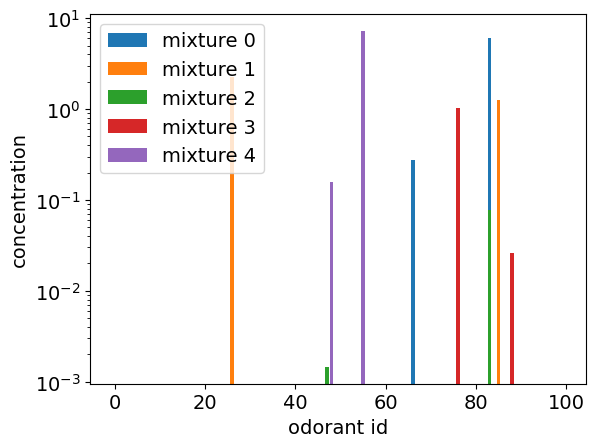

In [27]:
fig, ax = plt.subplots()
for i in range(5): 
    ax.bar(range(100), cs[:, i], label=f'mixture {i}')

ax.set_yscale('log') 
ax.legend()
ax.set_xlabel('odorant id') 
ax.set_ylabel('concentration') 
fig.savefig('tmp.png')

In [7]:
r_init = os.compute_activity(Ws[0], cs, key) 

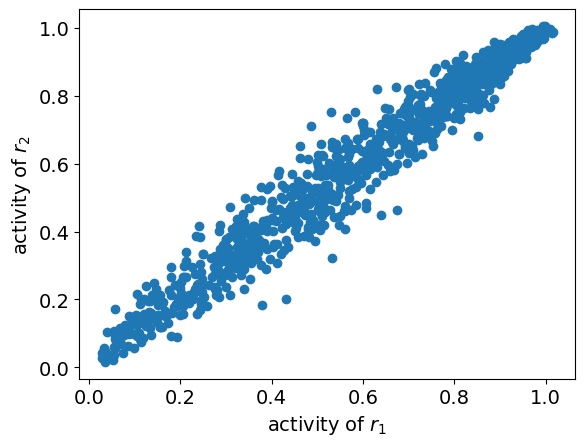

In [11]:
fig, ax = plt.subplots()
ax.scatter(r_init[0, :], r_init[1, :])
ax.set_xlabel(r'activity of $r_1$')
ax.set_ylabel(r'activity of $r_2$')
fig.savefig('tmp.png')

In [8]:
r_final = os.compute_activity(Ws[-1], cs, key) 

In [9]:
def plot_W_and_activity_in_2D(W_init, r_init, W_opt, r_opt, entropy): 
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].scatter(W_init[0, :], W_init[1, :], label='W_init', alpha=0.7)
    axs[0].scatter(W_opt[0, :], W_opt[1, :], label='W_opt', alpha=0.7)
    axs[1].scatter(r_init[0, :], r_init[1, :], label='r_init', alpha=0.7)
    axs[1].scatter(r_opt[0, :], r_opt[1, :], label='r_opt', alpha=0.7)
    axs[0].set_title(r'$W_{j}$')
    axs[0].set_xlabel(r'$W_{1j}$')
    axs[0].set_ylabel(r'$W_{2j}$')
    axs[1].set_title('activity') 
    axs[1].set_xlabel(r'$r_1$')
    axs[1].set_ylabel(r'$r_2$')
    axs[2].plot(range(len(entropy)), entropy)
    axs[2].set_xlabel('epoch') 
    axs[2].set_ylabel(r'$-H(r)$')
    axs[2].set_title('entropy') 
    return axs 


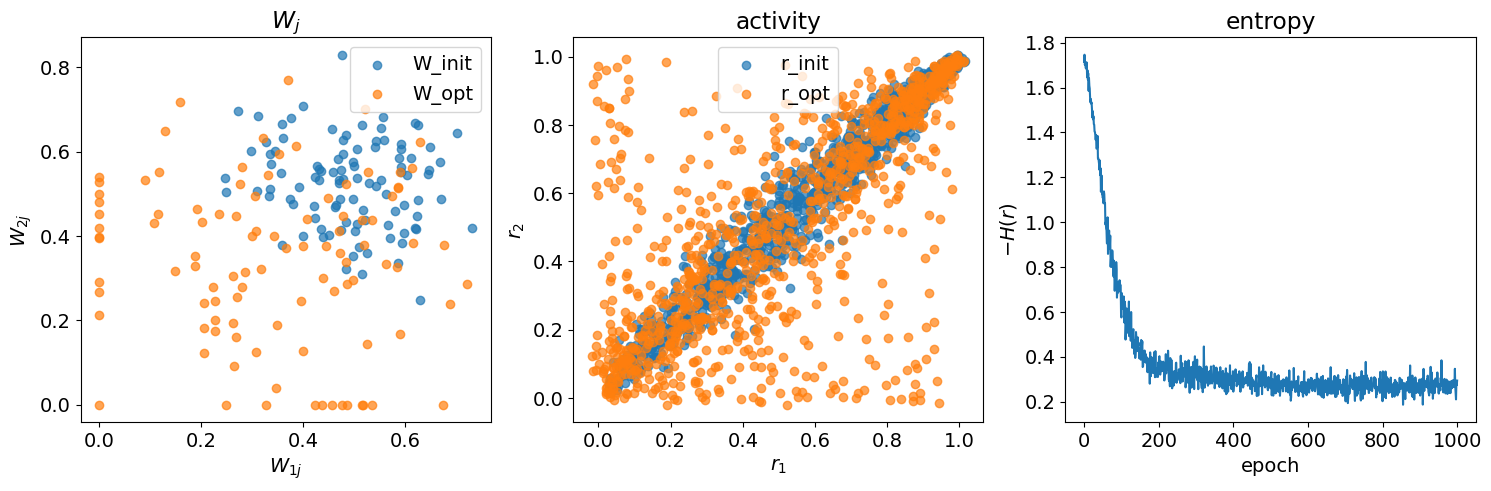

In [10]:
W_init = Ws[0]
W_final = jnp.minimum(Ws[-1], 1) 
axs = plot_W_and_activity_in_2D(W_init, r_init, W_final, r_final, ents)
axs[0].legend()
axs[1].legend()

Why is this so much slower than it used to be for $N = 100, M=30$? 

# M = 30

In [109]:
# Maximization with respect to W




# Set up JAX optimizer
N, n, M, P = 100, 2, 30, 1000
os = OlfactorySensing(N=N, n=n, M=M, P=P)
key = jax.random.PRNGKey(0)
os.cs = os.draw_cs(key=key) 
W_init = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(M, N)) + 0 
os.W = W_init 


Todos: 
1) get jit working on the top level function 
1) smaller P? then it's too noisy. 

In [8]:
def run_optimization(os, key, W_init, n_steps=int(2e3), param='square', stepsize=1e-3): 
    opt_init, opt_update, get_params = optimizers.adam(stepsize)
    opt_state = opt_init(W_init)
    ent_values = []
    vals = []
    print_interval = round(n_steps / 10) 
    for i in range(n_steps):
        key, subkey = jax.random.split(key)
        opt_state, entropy_value = step(i, opt_state, opt_update, get_params, subkey, os, param)
        ent_values.append(entropy_value)
        vals.append(get_params(opt_state)) 
        if i % print_interval == 0:
            print(f"Step {i}, Estimated Entropy: {-entropy_value}")

    W_opt = get_params(opt_state).reshape((os.M, os.N))
    print("Optimized W:", W_opt)
    return ent_values, W_opt 

In [111]:
ent_values, W_opt = run_optimization(os, key, W_init, n_steps=200, param='square')

Step 0, Estimated Entropy: -56.58069610595703
Step 20, Estimated Entropy: -32.96516418457031
Step 40, Estimated Entropy: -28.4112548828125
Step 60, Estimated Entropy: -27.30039405822754
Step 80, Estimated Entropy: -26.303327560424805
Step 100, Estimated Entropy: -26.840112686157227
Step 120, Estimated Entropy: -25.911903381347656
Step 140, Estimated Entropy: -25.18836784362793
Step 160, Estimated Entropy: -24.71824073791504
Step 180, Estimated Entropy: -24.91245460510254
Optimized W: [[-0.6202036  -0.53025126 -0.51249486 ... -0.00199943  0.56627715
   0.56262875]
 [ 0.459413   -0.557106    0.6248363  ... -0.5517131   0.49679315
   0.47998932]
 [ 0.47026578 -0.5471619   0.39777362 ...  0.6223482   0.492981
   0.5606838 ]
 ...
 [ 0.5066276  -0.5188239   0.45037094 ...  0.5191875   0.529701
  -0.47246507]
 [ 0.526841    0.46515575 -0.5244575  ... -0.53535515  0.58482605
   0.5858438 ]
 [ 0.70742685 -0.582889   -0.49352363 ... -0.49107224  0.5336391
   0.58670396]]


In [112]:
W2 = W_opt**2

Text(0.5, 0.98, '$N=100, M=2, n=2$')

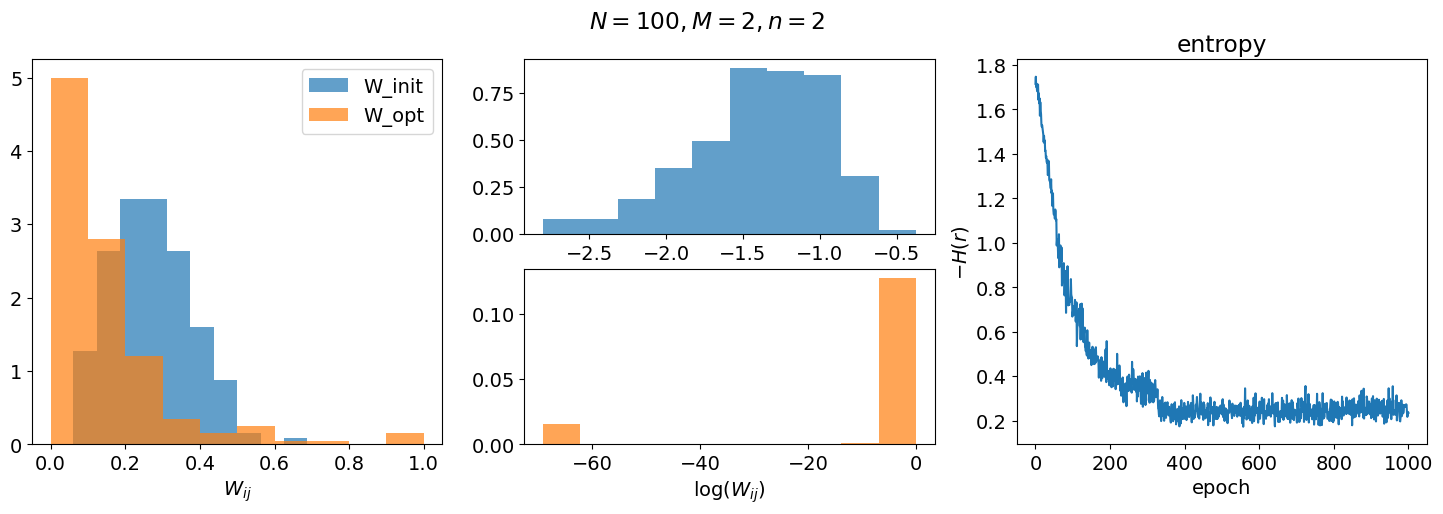

In [103]:
def plot_W(W_init, W_opt, entropies): 
    fig = plt.figure(figsize=(18, 5))

    # Create a GridSpec layout with 2 rows and 3 columns
    gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)

    # Add axes
    ax1 = fig.add_subplot(gs[:, 0])  # First column spans both rows
    ax2_top = fig.add_subplot(gs[0, 1])  # Top half of the middle column
    ax2_bottom = fig.add_subplot(gs[1, 1])  # Bottom half of the middle column
    ax3 = fig.add_subplot(gs[:, 2]) 

    epsilon = 1e-30 
    W_opt_square_pos = jnp.where(W_opt**2 == 0, epsilon, W_opt**2)
    ax1.hist(W_init.flatten()**2, alpha=0.7, label='W_init', density=True)
    ax1.hist(W_opt_square_pos.flatten(), alpha=0.7, label='W_opt', density=True) 
    ax1.set_xlabel(r'$W_{ij}$')
    ax2_top.hist(jnp.log(W_init.flatten()**2), alpha=0.7, label='W_init', density=True, color='tab:blue')
    ax2_bottom.hist(jnp.log(W_opt_square_pos.flatten()), alpha=0.7, label='W_opt', density=True, color='tab:orange') 
    ax2_bottom.set_xlabel(r'$\log(W_{ij})$')
    ax1.legend()
    ax3.plot(range(len(entropies)), entropies)
    ax3.set_title('entropy') 
    ax3.set_ylabel(r'$-H(r)$')
    ax3.set_xlabel('epoch') 
    return fig

fig = plot_W(W_init, W_final, ents) 
fig.suptitle(rf'$N={os.N}, M={os.M}, n={os.n}$')


In [104]:
jnp.sum(W_final.flatten() < 1e-5)

Array(22, dtype=int32)

fig, ax = plt.subplots()
epsilon = 1e-30 
W_opt_square_pos = jnp.where(W_opt**2 == 0, epsilon, W_opt**2)
ax.hist(jnp.log((W_opt_square_pos).flatten()))

# Again check that mutual information increases with covariance

In [123]:
def compute_information(c, os, P, key): 
    cov = c * jnp.ones((30, 30))
    for i in range(cov.shape[0]): 
        cov = cov.at[i, i].set(1) 
    mean = jnp.zeros(cov.shape[0])  # Assuming a zero mean, adjust as needed
    os.r = jax.random.multivariate_normal(key, mean=mean, cov=cov, shape=(P,)).T
    I = os.compute_information_of_r(os.r)
    return I

I = compute_information(0, os, 1000, key)

In [124]:
Is = []

for c in jnp.linspace(0, .9, 10): 
    I = compute_information(c, os, 1000, key)
    Is.append(I) 

Text(0, 0.5, 'MI(r)')

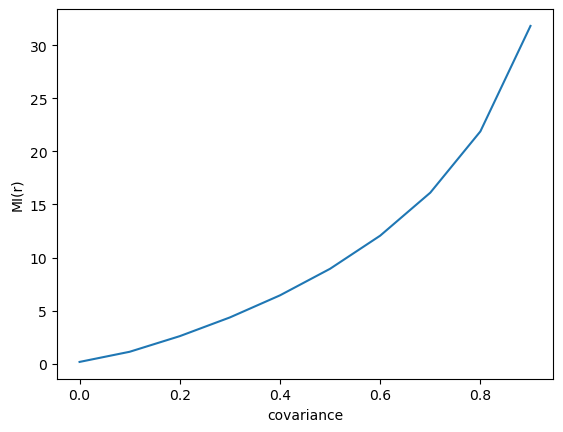

In [125]:
fig, ax = plt.subplots()
ax.plot(jnp.linspace(0, .9, 10), Is)
ax.set_xlabel('covariance') 
ax.set_ylabel('MI(r)')


Making the class a pytree: see https://jax.readthedocs.io/en/latest/faq.html#strategy-3-making-customclass-a-pytree

# varying $\sigma_c$ and computing sparsity of resulting optimal matrix. 
To do this we need to make sure the optimization has converged.  

In [203]:
# Set up JAX optimizer
N, n, M, P = 50, 13, 2, 500
os = OlfactorySensing(N=N, n=n, M=M, P=P)
key = jax.random.PRNGKey(0)
os.cs = os.draw_cs(key=key) 
W_init = 1 / jnp.sqrt(os.N) * jax.random.normal(key, shape=(M, N))
os.W = W_init 

In [ ]:
def sigma_sweep(sigmas, os, key): 
    for sigma in sigmas: 
        os.sigma_c = sigma
        os.cs = os.draw_cs(key=key)
        ent_values, W_opt = run_optimization(os, key, n_steps=100)
    


In [204]:
ent_values, W_opt = run_optimization(os, key, n_steps=100)

Step 0, Estimated Entropy: -2.1681997776031494
Step 10, Estimated Entropy: -2.153330087661743
Step 20, Estimated Entropy: -2.258831024169922
Step 30, Estimated Entropy: -2.284877061843872
Step 40, Estimated Entropy: -2.2320432662963867
Step 50, Estimated Entropy: -2.030531406402588
Step 60, Estimated Entropy: -2.352952003479004
Step 70, Estimated Entropy: -2.1860949993133545
Step 80, Estimated Entropy: -2.156109094619751
Step 90, Estimated Entropy: -2.1543312072753906
Optimized W: [[0.01503923 0.02260531 0.02103782 0.01989965 0.01743774 0.02136089
  0.02033723 0.01914442 0.01893317 0.01893076 0.01594459 0.01688551
  0.02374524 0.02072247 0.01781529 0.0231046  0.01858252 0.01897052
  0.01534306 0.02053148 0.0186871  0.02432848 0.02263266 0.02124037
  0.01963389 0.01933734 0.02068781 0.01949303 0.02342886 0.01586257
  0.02390296 0.01425803 0.01924578 0.0218793  0.02043209 0.02155012
  0.01956205 0.0176628  0.02272165 0.01778134 0.0215741  0.01938333
  0.02028756 0.02387992 0.02471325 0.0